<a href="https://colab.research.google.com/github/raguram/eva/blob/master/S12/ImageNet_Assignment12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount the drive and load required modules

In [1]:
from os.path import join
import sys
from google.colab import drive

# Mount the drive
ROOT = "/content/drive"
drive.mount(ROOT, force_remount=True)

LIBRARY_ROOT = "/content/drive/My Drive/Colab Notebooks/workspace/eva/cnn-lib/src"
sys.path.append(LIBRARY_ROOT)
sys.path.append(LIBRARY_ROOT + "/cnnlib")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install albumentations==0.4.5


     |████████████████████████████████| 122kB 4.6MB/s 
     |████████████████████████████████| 634kB 15.1MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=64378 sha256=bcadc29607baf68a3247c2817a561414b202c9cd946f3214ad4980d0924dd320
  Stored in directory: /root/.cache/pip/wheels/f0/a0/61/e50f93165a5ec7e7f5d65064e513239505bc4c06d2289557d3
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=1b98625f26d85cfb2c16eb1563c8b5cf932175486d760aaffce6031711098c23
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built albumentations imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [3]:
from torchvision import datasets, transforms
from cnnlib.ModelBuilder import ModelTester
import torch
import Utility 
import DataUtility
import MetricsUtility
import ModelBuilder
from Functions import LossFn
import torch.nn.functional as F
import torch.optim as optim
from ModelBuilder import ModelBuilder
import models.Resnet as Resnet
import torch.nn as nn
from albumentations import *
from albumentations.pytorch import ToTensor
import numpy as np
from DataUtility import Alb
import cv2
from lr_finder import LRFinder
from torch.optim.lr_scheduler import OneCycleLR

  pip install torch-lr-finder -v --global-option="amp"


### Download the Tiny Imagenet dataset


In [4]:
import requests
from os import path
from zipfile import ZipFile

if(path.exists("tiny-imagenet-200") != True):
  url = 'http://cs231n.stanford.edu/tiny-imagenet-200.zip'
  r = requests.get(url, allow_redirects=True)
  with open('tiny-imagenet-200.zip', 'wb') as f:
    f.write(r.content)
  with ZipFile('tiny-imagenet-200.zip', 'r') as zipObj:
   zipObj.extractall()
  print("Downloaded dataset to tiny-imagenet-200 folder")
else: 
  print("Dataset already exisits")


Downloaded dataset to tiny-imagenet-200 folder


### Load the data and perform required transformations

Shape of a train data batch: torch.Size([128, 3, 64, 64])
Shape of a test data batch: torch.Size([128, 3, 64, 64])
Number of train images: 100000
Number of test images: 10000


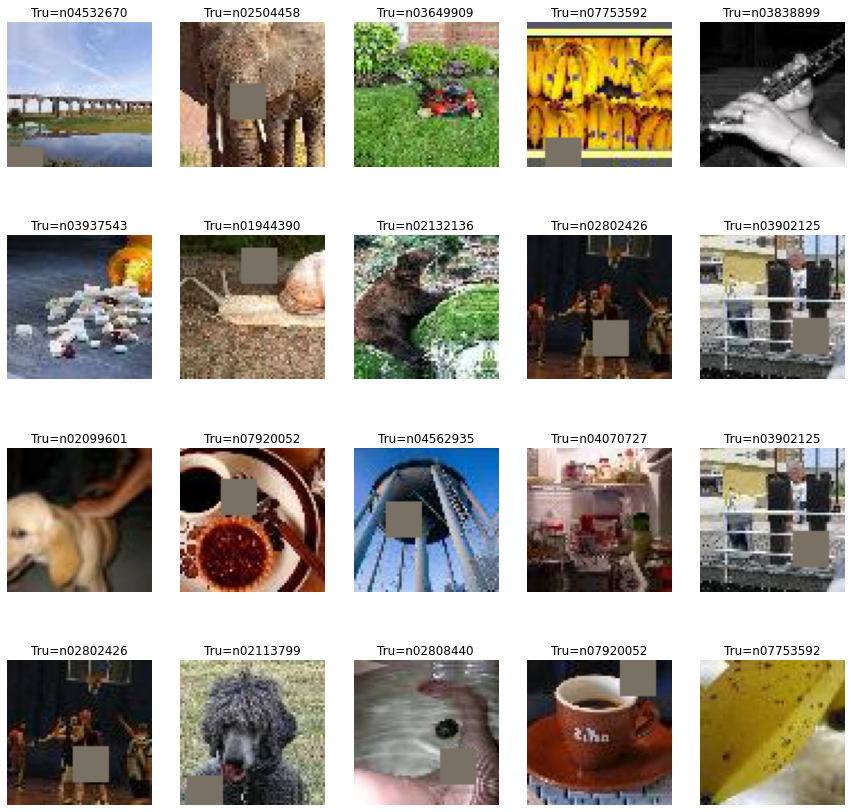

In [5]:
mean = [0.4804, 0.4482, 0.3975]
std = [0.0004, 0.0007, 0.0011]

train_transforms = Compose([
                            PadIfNeeded(72, 72, always_apply=True, p=1.0),
                            RandomCrop(64, 64, always_apply=True, p=1.0),
                            HorizontalFlip(p=0.5),
                            Cutout(num_holes=1, max_h_size=16, max_w_size=16, fill_value=np.array([*mean])*255.0, p=0.75),
                            Normalize(mean, std),
                            ToTensor()
])
  
test_transforms = Compose([
          Normalize(mean, std),
          ToTensor()
          ])

data=DataUtility.loadTinyImagenet("tiny-imagenet-200", Alb(train_transforms), Alb(test_transforms), batch_size=128)
DataUtility.showLoaderImages(data.train, count=20, classes=data.classes, muSigmaPair=(mean, std))

## Initialize the network and view the summary

In [6]:
from torchsummary import summary
summary(Resnet.ResNet(Resnet.BasicBlock, [2,2,2,2], num_classes=200).to(Utility.getDevice()), (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNorm2d-14          [-1, 128,

In [0]:
net = Resnet.ResNet(Resnet.BasicBlock, [2,2,2,2], num_classes=200).to(Utility.getDevice())
criterion = LossFn(nn.CrossEntropyLoss(), model=net, l2Factor=0.01)

## Train the network

In [8]:
LR = 0.1
epochs = 40
optimizer = optim.SGD(net.parameters(), lr = LR, momentum=0.9)
scheduler = OneCycleLR(optimizer, max_lr=LR, epochs=epochs, steps_per_epoch=len(data.train), 
                       pct_start=6/epochs, anneal_strategy='linear', div_factor=25.0, final_div_factor=1000)
builder = ModelBuilder(net, data, criterion, optimizer, scheduler)
result = builder.fit(epochs)



Epoch: 1



Train Accuracy: 8.832%, Train Loss: 0.0405033715069294, Learning Rate: 0.004



Test Accuracy: 12.14%, Test Loss: 0.039403464645147324


Epoch: 2



Train Accuracy: 20.064%, Train Loss: 0.03390079364180565, Learning Rate: 0.020003410786612663



Test Accuracy: 20.56%, Test Loss: 0.03384195640683174


Epoch: 3



Train Accuracy: 28.178%, Train Loss: 0.030309364199638367, Learning Rate: 0.03600682157322532



Test Accuracy: 27.1%, Test Loss: 0.03142879903316498


Epoch: 4



Train Accuracy: 34.694%, Train Loss: 0.02787790261209011, Learning Rate: 0.05201023235983798



Test Accuracy: 32.41%, Test Loss: 0.02910040132701397


Epoch: 5



Train Accuracy: 39.509%, Train Loss: 0.026071349158883095, Learning Rate: 0.06801364314645066



Test Accuracy: 38.25%, Test Loss: 0.027168523520231247


Epoch: 6



Train Accuracy: 43.948%, Train Loss: 0.024629782885313034, Learning Rate: 0.08401705393306332



Test Accuracy: 36.91%, Test Loss: 0.028485888615250587


Epoch: 7



Train Accuracy: 47.488%, Train Loss: 0.023500271141529083, Learning Rate: 0.09999623905521289



Test Accuracy: 40.14%, Test Loss: 0.027096819132566452


Epoch: 8



Train Accuracy: 50.736%, Train Loss: 0.022443309426307678, Learning Rate: 0.09705518023168347



Test Accuracy: 45.29%, Test Loss: 0.025204239413142204


Epoch: 9



Train Accuracy: 53.517%, Train Loss: 0.02158321812748909, Learning Rate: 0.09411412140815406



Test Accuracy: 44.98%, Test Loss: 0.02615385688841343


Epoch: 10



Train Accuracy: 56.323%, Train Loss: 0.020854569971561432, Learning Rate: 0.09117306258462465



Test Accuracy: 48.55%, Test Loss: 0.02448710799217224


Epoch: 11



Train Accuracy: 58.505%, Train Loss: 0.020247485488653183, Learning Rate: 0.08823200376109523



Test Accuracy: 50.5%, Test Loss: 0.02421080321073532


Epoch: 12



Train Accuracy: 60.627%, Train Loss: 0.019688261672854424, Learning Rate: 0.08529094493756582



Test Accuracy: 50.99%, Test Loss: 0.02438124269247055


Epoch: 13



Train Accuracy: 62.596%, Train Loss: 0.01919366605579853, Learning Rate: 0.08234988611403642



Test Accuracy: 50.16%, Test Loss: 0.025141915306448936


Epoch: 14



Train Accuracy: 64.741%, Train Loss: 0.01873909682035446, Learning Rate: 0.079408827290507



Test Accuracy: 52.19%, Test Loss: 0.024516044184565544


Epoch: 15



Train Accuracy: 66.307%, Train Loss: 0.01833161525428295, Learning Rate: 0.07646776846697759



Test Accuracy: 52.82%, Test Loss: 0.024529438465833664


Epoch: 16



Train Accuracy: 68.298%, Train Loss: 0.017913032323122025, Learning Rate: 0.07352670964344818



Test Accuracy: 53.07%, Test Loss: 0.02458813041448593


Epoch: 17



Train Accuracy: 69.868%, Train Loss: 0.017573853954672813, Learning Rate: 0.07058565081991877



Test Accuracy: 53.78%, Test Loss: 0.024951841682195663


Epoch: 18



Train Accuracy: 71.295%, Train Loss: 0.017213009297847748, Learning Rate: 0.06764459199638935



Test Accuracy: 53.13%, Test Loss: 0.025702426210045815


Epoch: 19



Train Accuracy: 73.281%, Train Loss: 0.01684245653450489, Learning Rate: 0.06470353317285994



Test Accuracy: 53.13%, Test Loss: 0.026190750300884247


Epoch: 20



Train Accuracy: 74.924%, Train Loss: 0.016457263380289078, Learning Rate: 0.06176247434933053



Test Accuracy: 55.14%, Test Loss: 0.025375816971063614


Epoch: 21



Train Accuracy: 76.391%, Train Loss: 0.01617491990327835, Learning Rate: 0.05882141552580112



Test Accuracy: 53.42%, Test Loss: 0.02662423625588417


Epoch: 22



Train Accuracy: 78.222%, Train Loss: 0.0157927256077528, Learning Rate: 0.055880356702271705



Test Accuracy: 54.95%, Test Loss: 0.02669914811849594


Epoch: 23



Train Accuracy: 79.497%, Train Loss: 0.01550108753144741, Learning Rate: 0.0529392978787423



Test Accuracy: 55.06%, Test Loss: 0.026961300522089005


Epoch: 24



Train Accuracy: 81.269%, Train Loss: 0.015125547535717487, Learning Rate: 0.049998239055212876



Test Accuracy: 54.38%, Test Loss: 0.027440819889307022


Epoch: 25



Train Accuracy: 82.8%, Train Loss: 0.014800088480114937, Learning Rate: 0.047057180231683475



Test Accuracy: 55.02%, Test Loss: 0.027885161340236664


Epoch: 26



Train Accuracy: 84.387%, Train Loss: 0.014418181963264942, Learning Rate: 0.04411612140815406



Test Accuracy: 55.62%, Test Loss: 0.0279797725379467


Epoch: 27



Train Accuracy: 86.014%, Train Loss: 0.014027648605406284, Learning Rate: 0.04117506258462465



Test Accuracy: 56.13%, Test Loss: 0.027890920639038086


Epoch: 28



Train Accuracy: 87.573%, Train Loss: 0.01367491576820612, Learning Rate: 0.03823400376109524



Test Accuracy: 54.66%, Test Loss: 0.02866470254957676


Epoch: 29



Train Accuracy: 89.094%, Train Loss: 0.01331446785479784, Learning Rate: 0.03529294493756582



Test Accuracy: 56.84%, Test Loss: 0.02808651141822338


Epoch: 30



Train Accuracy: 90.692%, Train Loss: 0.01290347520262003, Learning Rate: 0.032351886114036416



Test Accuracy: 56.91%, Test Loss: 0.02807575650513172


Epoch: 31



Train Accuracy: 92.364%, Train Loss: 0.012450795620679855, Learning Rate: 0.029410827290507008



Test Accuracy: 56.66%, Test Loss: 0.02816472016274929


Epoch: 32



Train Accuracy: 93.949%, Train Loss: 0.012038184329867363, Learning Rate: 0.026469768466977586



Test Accuracy: 58.04%, Test Loss: 0.028028490021824837


Epoch: 33



Train Accuracy: 95.421%, Train Loss: 0.011620129458606243, Learning Rate: 0.02352870964344818



Test Accuracy: 58.62%, Test Loss: 0.0279989130795002


Epoch: 34



Train Accuracy: 96.544%, Train Loss: 0.01128044817596674, Learning Rate: 0.02058765081991877



Test Accuracy: 58.94%, Test Loss: 0.02770550735294819


Epoch: 35



Train Accuracy: 97.488%, Train Loss: 0.010966838337481022, Learning Rate: 0.01764659199638935



Test Accuracy: 59.3%, Test Loss: 0.027309533208608627


Epoch: 36



Train Accuracy: 98.346%, Train Loss: 0.010661261156201363, Learning Rate: 0.014705533172859941



Test Accuracy: 60.21%, Test Loss: 0.02694045379757881


Epoch: 37



Train Accuracy: 98.794%, Train Loss: 0.010448469780385494, Learning Rate: 0.01176447434933052



Test Accuracy: 60.71%, Test Loss: 0.026561636477708817


Epoch: 38



Train Accuracy: 99.148%, Train Loss: 0.01027272641658783, Learning Rate: 0.008823415525801112



Test Accuracy: 60.79%, Test Loss: 0.026336342096328735


Epoch: 39



Train Accuracy: 99.399%, Train Loss: 0.010147790424525738, Learning Rate: 0.005882356702271704



Test Accuracy: 61.31%, Test Loss: 0.026047445833683014


Epoch: 40



Train Accuracy: 99.493%, Train Loss: 0.010077634826302528, Learning Rate: 0.0029412978787422828



Test Accuracy: 61.34%, Test Loss: 0.026004433631896973


## Plot metrics and loss

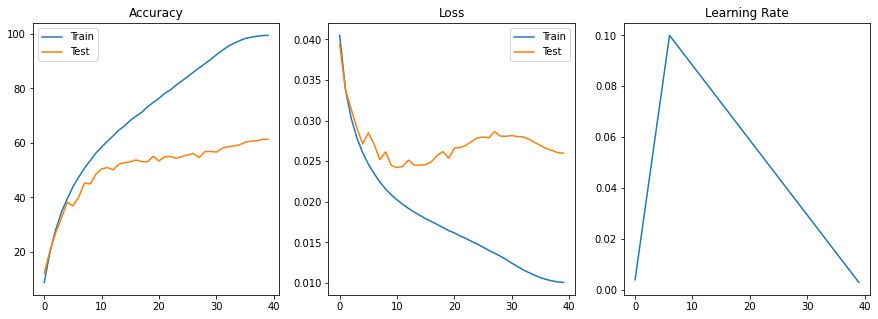

In [9]:
MetricsUtility.plotMetrics(result)

## View miss classified images


[[23  0  0 ...  0  0  0]
 [ 1 11  1 ...  3  0  0]
 [ 0  1 38 ...  0  0  0]
 ...
 [ 0  1  0 ... 30  0  0]
 [ 0  0  0 ...  0 29  0]
 [ 0  0  0 ...  1  0 37]]


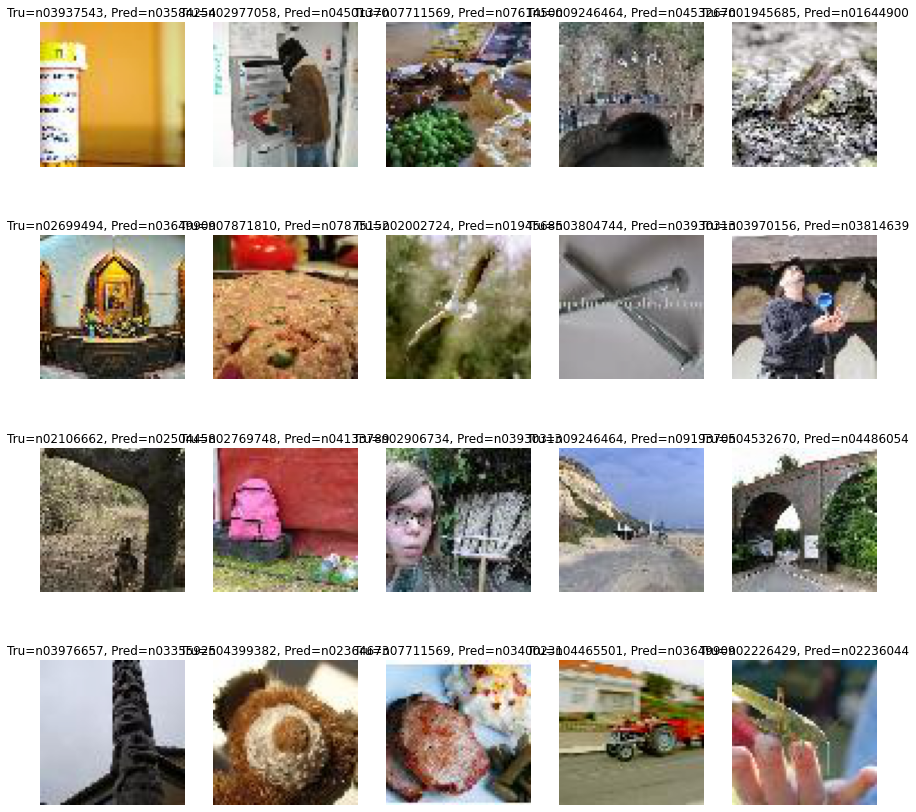

In [10]:
cpu = torch.device("cpu")
testResult = ModelTester().test(net, data.test, criterion)
metrics = MetricsUtility.computeMetrics(testResult.data, testResult.predictions, testResult.targets)
DataUtility.showRandomImages(metrics.miss_classified_data.to(cpu), metrics.miss_classified_targets.to(cpu), metrics.miss_classified_predictions.to(cpu), data.classes, muSigmaPair=(mean, std))